# Stage in-situ precipitation timeseries for a given AOI and time range and compare to rasters

In [1]:
import rioxarray as rxr
import xarray as xr
import xvec
import os
import geopandas as gpd
import xyzservices
import numpy as np
from zarr.storage import ObjectStore
from obstore.store import S3Store

In [2]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
geojson = "https://raw.githubusercontent.com/DSHydro/skagit-met/refs/heads/main/data/GIS/SkagitBoundary.json"
start = "2025-12-01"
end = "2025-12-16"
output = "s3://cresst/scratch/test.zarr"

## Stage data on S3 via CLI 

Note: I'm writing this under a 'scratch' prefix that automatically deletes after 2 weeks

In [4]:
# Run CLI
!gaia stage -i {geojson} -s {start} -e {end} --output {output}

Found 23 stations with precip data in the area of interest.
Station MMCW1 (USCRN SITE AT MARBLEMOUNT RANGER STATION NEAR DARRINGTON 21NNE): original interval = 0 days 00:05:00, resampling to hourly
Station UBKW1 (UPPER BAKER DAM NEAR CONCRETE 8NNE): original interval = 0 days 00:15:00, resampling to hourly
Station DARW1 (Darrington RS): original interval = 0 days 00:15:00, resampling to hourly
Station MARW1 (Marblemount): original interval = 0 days 00:15:00, resampling to hourly
Station COOPDARW1 (DARRINGTON RANGER STATION): original interval = 0 days 00:15:00, resampling to hourly
Station COOPMARW1 (MARBLEMOUNT RS): original interval = 0 days 00:15:00, resampling to hourly
Station MMCW1 (USCRN SITE AT MARBLEMOUNT RANGER STATION NEAR DARRINGTON 21NNE): original interval = 0 days 00:05:00, resampling to hourly
Station UBKW1 (UPPER BAKER DAM NEAR CONCRETE 8NNE): original interval = 0 days 00:15:00, resampling to hourly
Station DARW1 (Darrington RS): original interval = 0 days 00:15:00, r

In [5]:
# Check that it's there!
!aws s3 ls s3://cresst/scratch/

                           PRE test.zarr/


## Work with staged data 

Our bucket has anonymous read access, so anyone can access it

In [6]:
# General access to S3
s3readable = S3Store(
    bucket="cresst", prefix="scratch/test.zarr", region="us-west-2", skip_signature=True
)

# Zarr-aware handler for reading from S3
zarr_store = ObjectStore(s3readable, read_only=True)

In [7]:
DS = xr.open_dataset(zarr_store, engine="zarr", consolidated=False).xvec.decode_cf()
DS

<xarray.Dataset> Size: 59kB
Dimensions:                    (geometry: 19, time: 361)
Coordinates:
  * geometry                   (geometry) object 152B POINT (-120.7358 48.518...
    elevation                  (geometry) float64 152B ...
    station                    (geometry) <U9 684B ...
  * time                       (time) datetime64[ns] 3kB 2025-12-01 ... 2025-...
Data variables:
    precip_accumulated_set_1d  (geometry, time) float64 55kB ...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

In [8]:
# Reduce to single time step for GeoPandas
gf = DS.max(dim="time").xvec.to_geopandas()
gf.head()

,geometry,precip_accumulated_set_1d,elevation,station
0,POINT (-120.7358 48.51865),276.86,4890.0,RAIW1
1,POINT (-120.9895 48.52753),426.72,4320.0,THBW1
2,POINT (-121.81828 48.39236),501.39,2160.0,FIFW1
3,POINT (-121.54614 48.24294),365.25,3350.0,GHFW1
4,POINT (-120.78267 48.57142),373.38,3930.0,SWSW1


In [9]:
aoi = gpd.read_file(geojson)
# Basmap must be set on first map call
basemap = xyzservices.providers.CartoDB.Positron
m = aoi.explore(style_kwds={"color": "magenta", "fill": False}, tiles=basemap)
gf.explore(
    m=m, column="precip_accumulated_set_1d", popup=True, tooltip="station"
)  # , cmap='Blues', marker_kwds={'radius': 8})

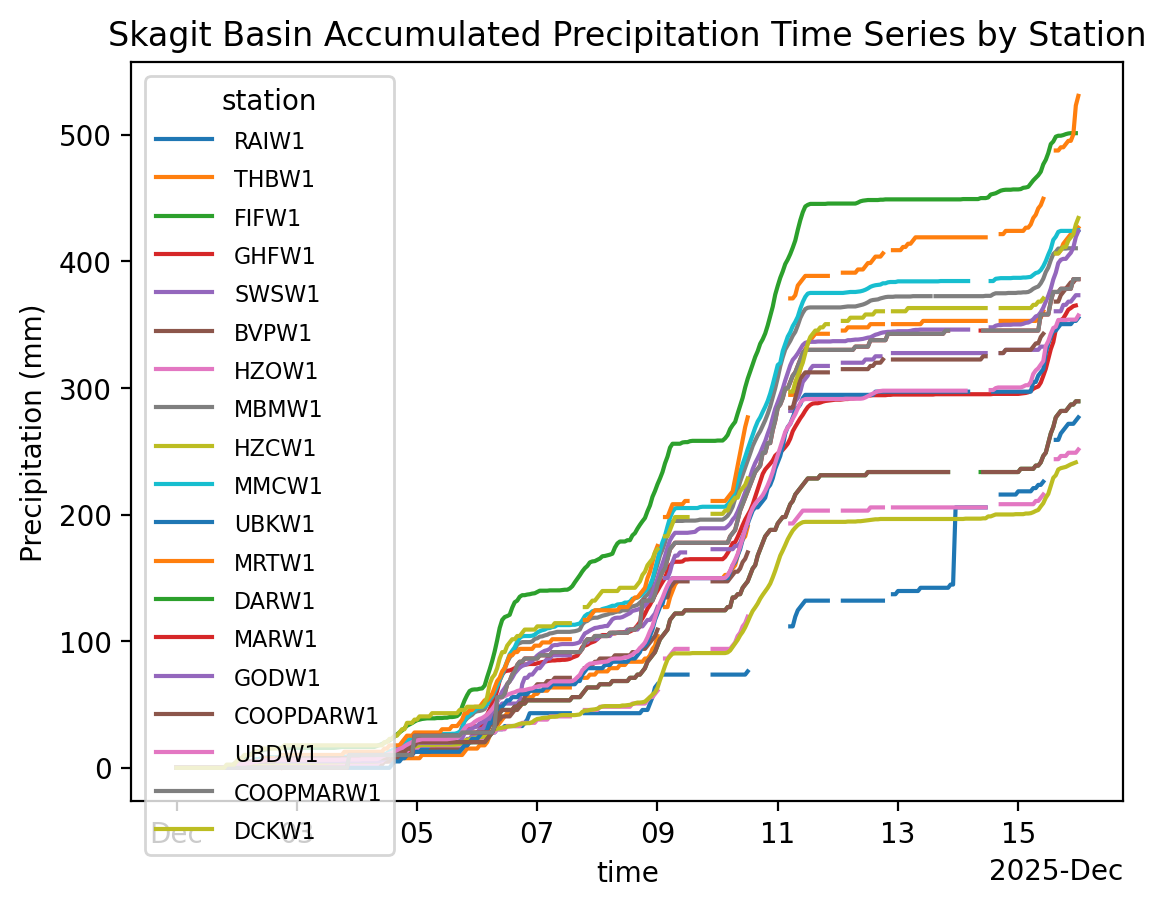

In [10]:
DA = DS["precip_accumulated_set_1d"]

fig, ax = plt.subplots()
DA.plot(ax=ax, x="time", hue="station")
legend = plt.gca().get_legend()
# legend.set_bbox_to_anchor((1.05, 1))
plt.setp(legend.get_texts(), fontsize=8)
legend.set_loc("upper left")
plt.title("Skagit Basin Accumulated Precipitation Time Series by Station")
plt.ylabel("Precipitation (mm)");

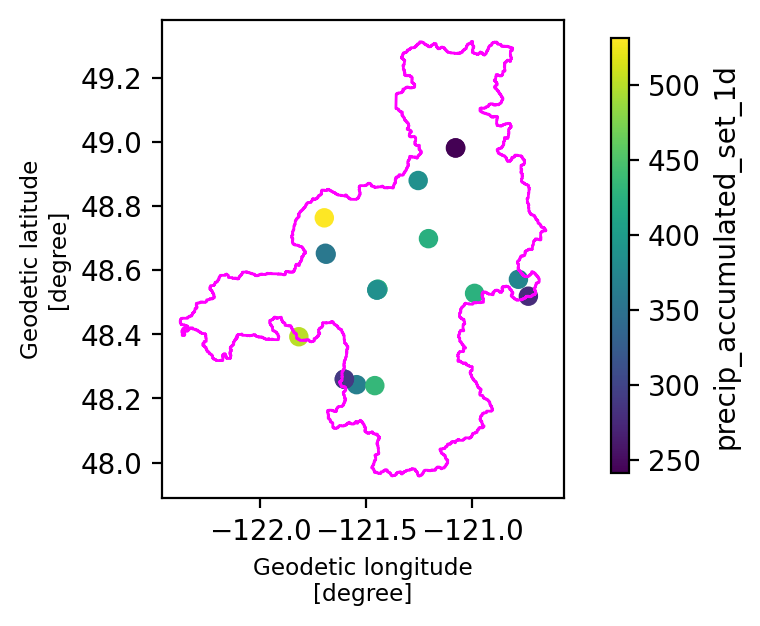

In [11]:
# Map view
# TODO: add station label annotations
fig, ax = DA.max(dim="time").xvec.plot()
aoi.plot(ax=ax, color="none", edgecolor="magenta");

### Compare stations to rasters

In [12]:
# Compare with raster
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"

# The data source is NOAA Stage IV, which is weather rader + rain gauge estimated precip at 4 km resolution.
url = "https://gaia-hazlab-map-data.s3.us-west-2.amazonaws.com/rainfall_4km.tif"
precip = rxr.open_rasterio(url).squeeze(drop=True)  # no need for 'band' coordinate
precip

<xarray.DataArray (y: 2330, x: 3619)> Size: 34MB
[8432270 values with dtype=float32]
Coordinates:
  * y            (y) float64 19kB 7.17e+06 7.168e+06 ... 2.514e+06 2.512e+06
  * x            (x) float64 29kB -1.447e+07 -1.447e+07 ... -7.235e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Accumulated rainfall
    units:          mm
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

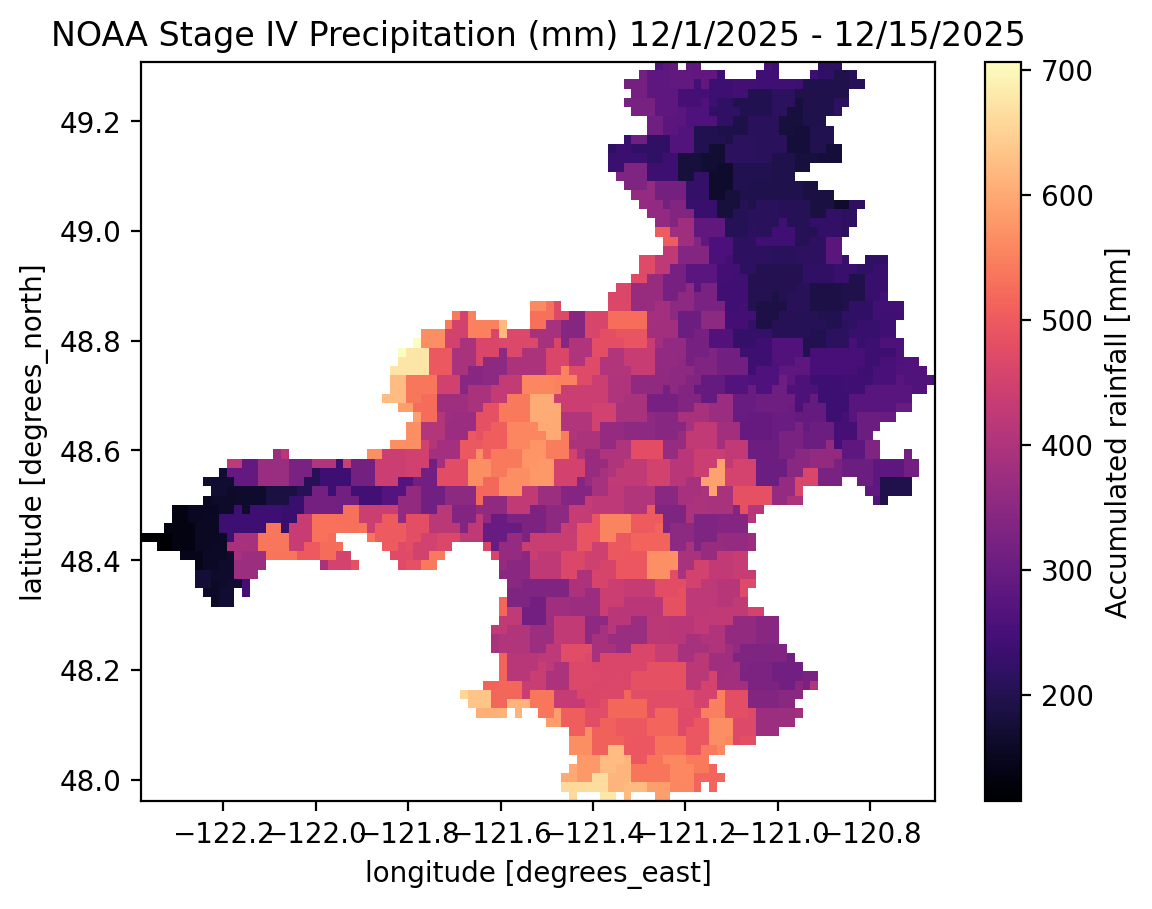

In [13]:
da = precip.rio.reproject("EPSG:4326")
da = da.rio.write_nodata(np.nan)
# da_clipped = da.rio.clip_box(minx=-125, miny=45, maxx=-115, maxy=50)
da_clipped = da.rio.clip(aoi.geometry)
da_clipped.plot.imshow(cmap="magma")
plt.title("NOAA Stage IV Precipitation (mm) 12/1/2025 - 12/15/2025");

In [14]:
# Sample raster at points with Xvec
# NOTE: nearest neighbor by defaul, can use geometrys or geodataframe, etc....
points = da.xvec.extract_points(
    DS.geometry.values, x_coords="x", y_coords="y", crs="EPSG:4326"
)
# THese use the same Geometry Index so we can just subtract them
residuals = points - DS["precip_accumulated_set_1d"].max(dim="time")

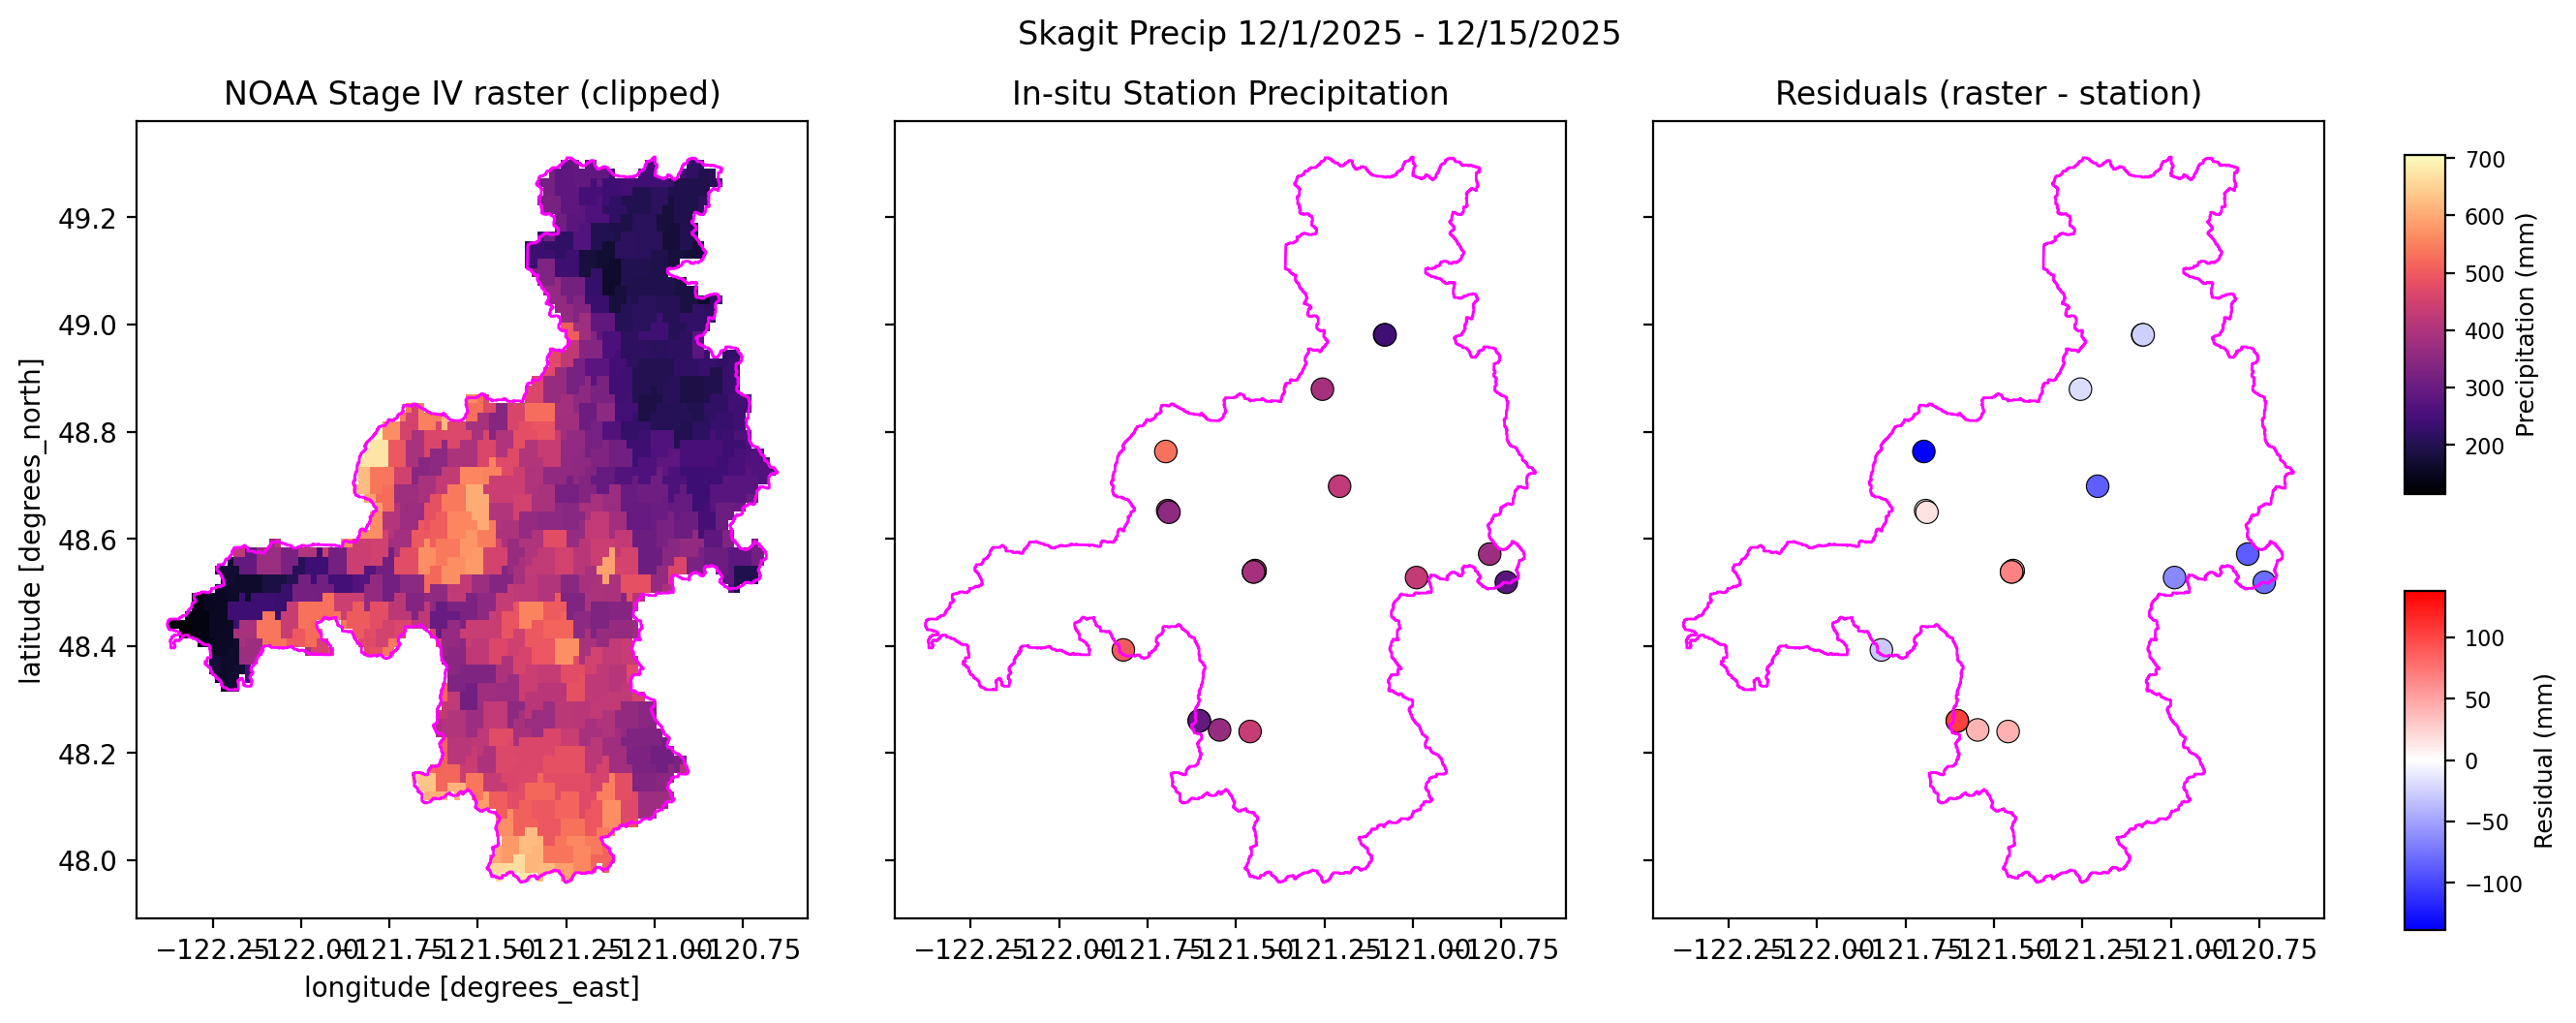

In [15]:
# 3x1 panel: raster, sampled points, residuals
# Assumes `da_clipped`, `points`, `residuals`, `DS`, and `aoi` are defined in earlier cells
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)

# Create geodataframe for station geometries and sampled values
gf = DS.max(dim="time").xvec.to_geopandas()
# ensure shapes align
gf["raster"] = points.values
gf["residual"] = residuals.values

# Shared color range for raster and sampled points
vmin = float(np.nanmin(da_clipped.values))
vmax = float(np.nanmax(da_clipped.values))

# Left: raster (no colorbar here)
im = da_clipped.plot.imshow(
    ax=axes[0], cmap="magma", add_colorbar=False, vmin=vmin, vmax=vmax
)
aoi.plot(ax=axes[0], facecolor="none", edgecolor="magenta")
axes[0].set_title("NOAA Stage IV raster (clipped)")

# Middle: sampled points colored by the raster sample (same cmap/scale)
sc = axes[1].scatter(
    gf.geometry.x,
    gf.geometry.y,
    c=gf["precip_accumulated_set_1d"],
    cmap="magma",
    vmin=vmin,
    vmax=vmax,
    s=70,
    edgecolor="k",
    linewidth=0.4,
)
aoi.plot(ax=axes[1], facecolor="none", edgecolor="magenta")
axes[1].set_title("In-situ Station Precipitation")

# Right: residuals with diverging 'bwr' colormap
rmax = float(np.nanmax(np.abs(gf["residual"].values)))
sc2 = axes[2].scatter(
    gf.geometry.x,
    gf.geometry.y,
    c=gf["residual"],
    cmap="bwr",
    vmin=-rmax,
    vmax=rmax,
    s=70,
    edgecolor="k",
    linewidth=0.4,
)
aoi.plot(ax=axes[2], facecolor="none", edgecolor="magenta")
axes[2].set_title("Residuals (raster - station)")

# Adjust layout to make room for colorbars on the right
plt.tight_layout()
fig.subplots_adjust(right=0.88)

# Add colorbars on the right side of the figure
# Shared colorbar for the first two panels (top half of right side)
cbar_ax1 = fig.add_axes([0.90, 0.55, 0.015, 0.35])
cbar1 = fig.colorbar(im, cax=cbar_ax1)
cbar1.set_label("Precipitation (mm)", fontsize=9)
cbar1.ax.tick_params(labelsize=8)

# Colorbar for residuals (bottom half of right side)
cbar_ax2 = fig.add_axes([0.90, 0.10, 0.015, 0.35])
cbar2 = fig.colorbar(sc2, cax=cbar_ax2)
cbar2.set_label("Residual (mm)", fontsize=9)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle("Skagit Precip 12/1/2025 - 12/15/2025", fontsize=12, y=1.04);